In [1]:
####### Calculation packages
####### 

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import pinv
import math
import random

####### Plotting packages
####### 

import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter, FormatStrFormatter

####### Formatting packages
####### 

import warnings
from time import time as tm
#from google.colab import files

####### self-defined packages
####### 
from HelperFuns import *

np.random.seed(2023)

####### Plotting
sns.set(context='paper',style='white',font_scale=1.2)
sns.set_palette('muted')
####### 

In [2]:
# First-time run simulation: True!
# Use stored simulation data: False!
runsims = True

# Setup

In [3]:
## this is for nD cost function
def W_nd_Costfun(Weight, G_nd, X_nd, r_hat_nd):
    A = inv(inv(G_nd) - Weight)
    return np.sum((A@X_nd-r_hat_nd)**2)/m

def A_nd_Costfun(A, X_nd, r_hat_nd):
    return np.sum((A@X_nd-r_hat_nd)**2)/m 

In [4]:
n = 200              # network size N = 200
G_nd= np.eye(n)      # connectivity matrix with diagnal = 1
invG_nd= inv(G_nd)   # to avoid multiple inverse calculations
m = 100#*5           # sample size (m>n, under-parameterized system)
sigma_x = .1
sigma_r = 0.01
X_nd = sigma_x*np.random.randn(n,m)

scale_stability = 0.5   # Girko's circular law
W_hat_nd = scale_stability*np.random.randn(n,n)*np.sqrt(1/n) # unit circle
plot_W_hat = np.linalg.eigvals(W_hat_nd)

## see how eigenvalue of W_hat spreads, notice that it's within a scaled unit circle
# plt.figure
# plt.scatter(np.real(plot_W_hat), np.imag(plot_W_hat))
# plt.show()

A_hat_nd = inv(invG_nd - W_hat_nd) 
r_hat_nd = A_hat_nd@X_nd + sigma_r*np.random.randn(n,m) 
Jacob_nd = -np.eye(n)+G_nd@W_hat_nd

## get optimal
A_star = r_hat_nd@X_nd.T@(inv(X_nd@X_nd.T)) # Underline minimizer 
A_star_psudo = r_hat_nd@pinv(X_nd)  # from psudo inverse

W_star = invG_nd-inv(A_star) # Underline minimizer 
W_star_psudo = invG_nd-inv(A_star_psudo) # from A+
W_star_try = (r_hat_nd-X_nd)@pinv(r_hat_nd) # self-derive

print(A_nd_Costfun(A_hat_nd, X_nd, r_hat_nd),
      A_nd_Costfun(A_star, X_nd, r_hat_nd),
      A_nd_Costfun(A_star_psudo, X_nd, r_hat_nd))

print(W_nd_Costfun(W_hat_nd, G_nd,X_nd, r_hat_nd),
      W_nd_Costfun(W_star, G_nd, X_nd, r_hat_nd),
      W_nd_Costfun(W_star_psudo, G_nd, X_nd, r_hat_nd),
      W_nd_Costfun(W_star_try,G_nd, X_nd, r_hat_nd))

# perturb several traces of W
num_paris = 10
perturb = 5#10
W1_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n)

## loss trace along (-1,1) segment,w
w = np.arange(-1.01, 1+0.01, 0.01) 
CostW_nd = np.zeros((num_paris,len(w)))
CostA_nd = np.zeros((num_paris,len(w)))

for k in range(num_paris):
#     W0 = W_hat_nd 
    W0 = W_star_try
    W1 = W1_set[k]
#     A0 = A_hat_nd 
    A0 = A_star_psudo
    A1 = inv(invG_nd-W1) 
    for i in range(len(w)):
        CostW_nd[k,i]=W_nd_Costfun(w[i]*W1 + W0, G_nd, X_nd, r_hat_nd)
        CostA_nd[k,i]=A_nd_Costfun(w[i]*A1 + A0, X_nd, r_hat_nd)
        

0.019916381505374798 1763.41569813652 1.103039248297159e-29
0.019916381505374798 1763.415698136522 7.273213052584765 5.998227578025878e-30


In [5]:
def CostValue_nd(num_paris, W_star_try, A_star_psudo, W1_set, W2_set, G_nd):
    x = y = np.arange(-1.01, 1 + 0.01, 0.01)
    CostW_nd_land = np.zeros((num_paris, len(x), len(y)))
    CostA_nd_land = np.zeros((num_paris, len(x), len(y)))
    for k in range(num_paris):
    # for k in range(1):
        W0 = W_star_try
        W1 = W1_set[k]
        W2 = W2_set[k]

        A0 = A_star_psudo
        A1 = inv(inv(G_nd) - W1)
        A2 = inv(inv(G_nd) - W2)
        for i in range(len(x)):
            for j in range((len(y))):
                CostW_nd_land[k, i, j] = W_nd_Costfun(((x[i] * W1 + y[j] * W2) + W0), G_nd, X_nd, r_hat_nd)
                CostA_nd_land[k, i, j] = A_nd_Costfun(((x[i] * A1 + y[j] * A2) + A0), X_nd, r_hat_nd)

    return (CostW_nd_land, CostA_nd_land)



x = y = np.arange(-1.01, 1+0.01, 0.01)
X, Y = np.meshgrid(x, y)
W1_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n) # already ran
W2_set = perturb*scale_stability*np.random.randn(num_paris,n,n)*np.sqrt(1/n)

CostW_nd_land = np.zeros((num_paris,len(x), len(y)))
CostA_nd_land = np.zeros((num_paris, len(x), len(y)))
for k in range(1):
    W0 = W_star_try
    W1 = W1_set[k]
    W2 = W2_set[k]

    A0 = A_star_psudo
    A1 = inv(invG_nd-W1) 
    A2 = inv(invG_nd-W2) 
    for i in range(len(x)):
        for j in range((len(y))):
            CostW_nd_land[k,i,j]=W_nd_Costfun((x[i]*W1 + y[j]*W2)+W0, G_nd, X_nd, r_hat_nd) # maybe 1/sqrt(2) not the 1/2
            CostA_nd_land[k,i,j]=A_nd_Costfun((x[i]*A1 + y[j]*A2)+A0, X_nd, r_hat_nd)


<ipython-input-38-11f59e14e117>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=minZ, vmax=maxZ)
<ipython-input-38-11f59e14e117>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['250','500','750','1000+'])
<ipython-input-38-11f59e14e117>:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=ax.pcolormesh(X,Y,Z1,cmap='hot',norm=LogNorm(vmin=minZ, vmax=maxZ))
<ipyt

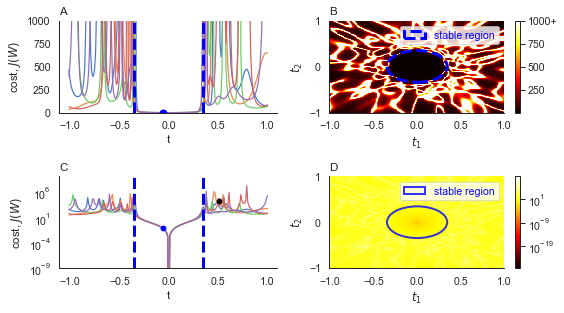

In [38]:
sns.set(context='paper',style='white',font_scale=1.2)
sns.set_palette('muted')

# fig = tools.make_subplots(rows=2, cols=2 ,print_grid=False)
## plotting the 1D landscape
# fig = plt.subplots(figsize = (8,4))
# fig = plt.figure(figsize=(8, 4))
fig = plt.figure(figsize=(8, 4.5))
fig.add_subplot(221)

# plt.subplots(figsize=(8,5))
# plt.subplot(2,2,1)
x = w
y1 = CostW_nd[0,:]
y2 = CostW_nd[1,:]
y3 = CostW_nd[3,:]
y4 = CostW_nd[4,:]
y5 = CostW_nd[5,:]

plt.ylim(0,1000)
plt.plot(x,y1,label='trace1')
plt.plot(x,y2,label='trace2')
plt.plot(x,y3,label='trace3')
plt.plot(x,y4,label='trace4')
plt.plot(x,y5,label='trace5')

# plt.plot(0, W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), '*', color = "red", markersize=15)
plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue",markersize=7)
plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0),G_nd, X_nd, r_hat_nd), 'o', color = "black",markersize=7)
plt.axvline(x=-(np.sqrt(1-scale_stability**2)/(scale_stability*perturb)), color='blue', linestyle='--', linewidth=3.0, alpha=1,label = "stability segment")
plt.axvline(x=np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--',linewidth=3.0, alpha=1,)

plt.title('A',loc='left')
plt.xlabel('t')
plt.ylabel('cost, $J(W)$')
plt.ylim(bottom=0)
sns.despine()
# plt.legend(bbox_to_anchor=(1,0.1), loc="lower right", fontsize = 'x-small')
# plt.tight_layout()
# plt.savefig('./Figures/Fig3A.eps',bbox_inches="tight")a


# plt.subplot(2,2,3)   
fig.add_subplot(222)
#### ploting a 2D landscape            
x = y = np.arange(-1.01, 1+0.01, 0.01)
X, Y = np.meshgrid(x, y)
for k in range(1):
### prepare for W landscape (in log scale)
    Z1 = CostW_nd_land[k,:,:].reshape(X.shape)
### heat map
    ax = fig.gca()
    maxZ=1000#Z1.max()
    minZ=0.01#Z1.min()
    c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=minZ, vmax=maxZ)
  # c=ax.pcolormesh(X,Y,Z1,cmap='hot',vmin=-1., vmax=1.)
    cbar = plt.colorbar(c, ax=ax)
    cbar.ax.set_yticklabels(['250','500','750','1000+'])
    circle1 = plt.Circle((0, 0), np.sqrt(1-scale_stability**2)/(scale_stability*perturb), fill=False, 
                         edgecolor='blue', linestyle='--', linewidth=3.0, alpha=1, label = "stable region")
    plt.gca().add_patch(circle1)
#     plt.legend(labelcolor='linecolor')
#     l = plt.legend(bbox_to_anchor=(0.4,0.9), loc="center left",fontsize = 'small')
    l = plt.legend()
    for text in l.get_texts():
        text.set_color("blue")
    plt.title('B',loc='left')
    plt.xlabel('$t_1$')
    plt.ylabel('$t_2$')
# plt.tight_layout()
# plt.savefig('./Figures/Fig3B.png',bbox_inches="tight")
sns.despine()

##### plot log-scale
fig.add_subplot(223)
x = w
y1 = CostW_nd[0,:]
y2 = CostW_nd[1,:]
y3 = CostW_nd[3,:]
y4 = CostW_nd[4,:]
y5 = CostW_nd[5,:]

plt.plot(x,y1,label='log trace 1')
plt.plot(x,y2,label='log trace 2')
plt.plot(x,y3,label='log trace3')
plt.plot(x,y4,label='log trace4')
plt.plot(x,y5,label='log trace5')

plt.plot(0, W_nd_Costfun(W_star_try, G_nd, X_nd, r_hat_nd), '*', color = "red", markersize=7)
plt.plot(w[100-5], W_nd_Costfun((w[100-5]*W1 + W0), G_nd, X_nd, r_hat_nd), 'o', color = "blue")
plt.plot(w[-(100-50)], W_nd_Costfun((w[-(100-50)]*W1 + W0),G_nd, X_nd, r_hat_nd), 'o', color = "black")
plt.axvline(x=-np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--', linewidth=3.0, alpha=1, label = "stability segment")
plt.axvline(x=np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', linestyle='--',linewidth=3.0, alpha=1)


plt.title('C',loc='left')
plt.xlabel('t')
plt.ylabel('cost, $J(W)$')
plt.yscale('log')
plt.ylim(bottom=1e-9)
sns.despine()

# plt.savefig('./Figures/Fig3C.eps',bbox_inches="tight")
# plt.show()

fig.add_subplot(224)
X, Y = np.meshgrid(x, y)
for k in range(1):
### prepare for W landscape (in log scale)
    Z1 = CostW_nd_land[k,:,:].reshape(X.shape)

### heat map
    ax = fig.gca()
    maxZ=Z1.max()
    minZ=Z1.min()
    c=ax.pcolormesh(X,Y,Z1,cmap='hot',norm=LogNorm(vmin=minZ, vmax=maxZ))
    fig.colorbar(c, ax=ax)
    circle1 = plt.Circle((0, 0), np.sqrt(1-scale_stability**2)/(scale_stability*perturb), color='blue', fill=False, 
                         edgecolor='blue', linewidth=2.0, alpha= 0.8, label = "stable region")
    plt.gca().add_patch(circle1)
#     l = plt.legend(bbox_to_anchor=(0.4,0.9), loc="center left",fontsize = 'small')
    l = plt.legend()
    for text in l.get_texts():
        text.set_color("blue")
   
    plt.title('D',loc='left')
    plt.xlabel('$t_1$')
    plt.ylabel('$t_2$')

# plt.savefig('./Figures/Fig3D.png',bbox_inches="tight")
sns.despine()
plt.tight_layout()
# plt.savefig('./Figures/LinearNDLoss.pdf')


plt.tight_layout()
plt.savefig('./Figures/LinearNDLoss.pdf')
